In [20]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from torch import nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt

%matplotlib inline

In [21]:
def visualize_predictions(X_test, y_test, predictions):
    
    preds = weight_scaler.inverse_transform(predictions.detach().numpy())
    actual = weight_scaler.inverse_transform(y_test.numpy().reshape((-1, 1)))
    inputs = weight_scaler.inverse_transform(X_test.numpy().reshape((-1, 1)))

    fig, ax = plt.subplots(figsize=(15, 12))

    sns.scatterplot(x=inputs.flatten(), y=preds.flatten(), ax=ax, color="blue")
    sns.scatterplot(x=inputs.flatten(), y=actual.flatten(), ax=ax, color="orange")

    plt.legend()

    ax.set_xlabel("player", fontdict={"size": 12}, labelpad=12)
    ax.set_ylabel("player_weight", fontdict={"size": 12}, labelpad=12)

    fig.show()

## Graphs in PyTorch

PyTorch internally tracks the operations done on all matrices within a series of operations and creates a [*graph*](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#computational-graph), this graph stores the required information while *propagating forward*, and calculates the gradients for each matrix *via chain rule* in *backpropagation*

## Example

### The Dataset

We're going to use a simple dataset for the purpose of demonstration.

The dataset from [Github gists](https://gist.github.com/nstokoe/7d4717e96c21b8ad04ec91f361b000cb) has three columns:
1. Gender (Male/Female)
2. Height (inches)
3. Weight (pounds)

In this exercise we want to predict the person's weight, given his height and gender

In [22]:
raw = pd.read_csv(
    filepath_or_buffer="https://gist.githubusercontent.com/nstokoe/802f1ddb646cba965a732ac5e0f97dca/raw/45313cfd519c4c30b1f3603704027e54366088b4/nba-height-weight.csv"
)

In [23]:
raw.head()

,Unnamed: 0,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,0,Chris Robinson,VAN,23.0,195.58,90.71840,Western Kentucky,USA,1996,2,...,4.6,1.7,1.6,-11.4,0.039,0.088,0.155,0.486,0.156,1996-97
1,1,Matt Fish,MIA,27.0,210.82,106.59412,North Carolina-Wilmington,USA,1992,2,...,0.3,0.8,0.0,-15.1,0.143,0.267,0.265,0.333,0.000,1996-97
2,2,Matt Bullard,HOU,30.0,208.28,106.59412,Iowa,USA,Undrafted,Undrafted,...,4.5,1.6,0.9,0.9,0.016,0.115,0.151,0.535,0.099,1996-97
3,3,Marty Conlon,BOS,29.0,210.82,111.13004,Providence,USA,Undrafted,Undrafted,...,7.8,4.4,1.4,-9.0,0.083,0.152,0.167,0.542,0.101,1996-97
4,4,Martin Muursepp,DAL,22.0,205.74,106.59412,NaN,USA,1996,1,...,3.7,1.6,0.5,-14.5,0.109,0.118,0.233,0.482,0.114,1996-97


In [24]:
raw.describe()

,Unnamed: 0,age,player_height,player_weight,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct
count,9561.000000,9561.000000,9561.000000,9561.000000,9561.000000,9561.000000,9561.000000,9561.000000,9561.000000,9561.000000,9561.000000,9561.000000,9561.000000,9561.000000
mean,4780.000000,27.336157,200.953442,100.975853,53.073528,8.070683,3.565161,1.788516,-2.214413,0.057963,0.142879,0.186582,0.504795,0.130812
std,2760.167296,4.350559,9.281158,12.780883,24.882139,5.888910,2.494161,1.793835,11.545131,0.044568,0.062211,0.052344,0.093493,0.095428
min,0.000000,18.000000,160.020000,60.327736,1.000000,0.000000,0.000000,0.000000,-200.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2390.000000,24.000000,195.580000,91.171992,34.000000,3.500000,1.800000,0.500000,-6.400000,0.023000,0.097000,0.152000,0.476000,0.063000
50%,4780.000000,27.000000,203.200000,100.697424,60.000000,6.600000,3.000000,1.200000,-1.400000,0.046000,0.134000,0.184000,0.518000,0.102000
75%,7170.000000,30.000000,208.280000,111.130040,75.000000,11.400000,4.700000,2.400000,3.100000,0.088000,0.184000,0.218000,0.552000,0.178000
max,9560.000000,44.000000,231.140000,163.293120,85.000000,35.400000,16.300000,11.700000,300.000000,1.000000,1.000000,1.000000,1.064000,1.000000


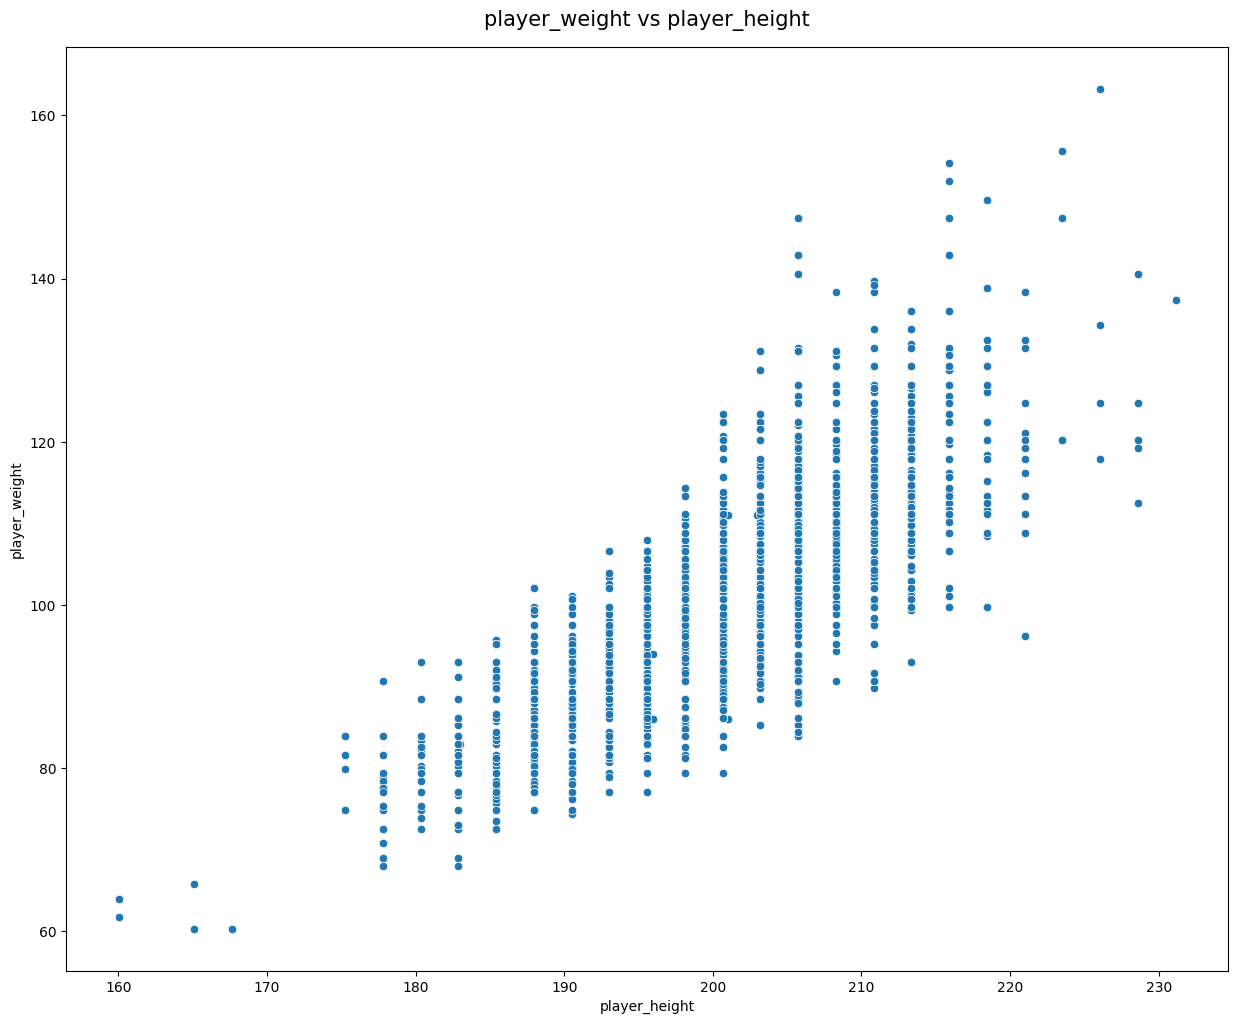

In [25]:
fig, ax = plt.subplots(figsize=(15, 12))

sns.scatterplot(data=raw, x="player_height", y="player_weight")
ax.set_title(label="player_weight vs player_height", fontdict=dict(size=15), pad=15)

plt.show()

#### Preprocessing

In [26]:
data = raw.copy(deep=True)

In [27]:
height_scaler = StandardScaler()
weight_scaler = StandardScaler()

data["player_height"] = height_scaler.fit_transform(data["player_height"].to_numpy().reshape(-1, 1)).flatten()
data["player_weight"] = weight_scaler.fit_transform(data["player_weight"].to_numpy().reshape(-1, 1)).flatten()

In [28]:
data.head()

,Unnamed: 0,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,0,Chris Robinson,VAN,23.0,-0.578993,-0.802604,Western Kentucky,USA,1996,2,...,4.6,1.7,1.6,-11.4,0.039,0.088,0.155,0.486,0.156,1996-97
1,1,Matt Fish,MIA,27.0,1.063130,0.439607,North Carolina-Wilmington,USA,1992,2,...,0.3,0.8,0.0,-15.1,0.143,0.267,0.265,0.333,0.000,1996-97
2,2,Matt Bullard,HOU,30.0,0.789443,0.439607,Iowa,USA,Undrafted,Undrafted,...,4.5,1.6,0.9,0.9,0.016,0.115,0.151,0.535,0.099,1996-97
3,3,Marty Conlon,BOS,29.0,1.063130,0.794524,Providence,USA,Undrafted,Undrafted,...,7.8,4.4,1.4,-9.0,0.083,0.152,0.167,0.542,0.101,1996-97
4,4,Martin Muursepp,DAL,22.0,0.515755,0.439607,NaN,USA,1996,1,...,3.7,1.6,0.5,-14.5,0.109,0.118,0.233,0.482,0.114,1996-97


#### Vectorisation &  Train Test Split

In [29]:
X = data["player_height"]
y = data["player_weight"]

In [30]:
X.head()

0   -0.578993
1    1.063130
2    0.789443
3    1.063130
4    0.515755
Name: player_height, dtype: float64

In [31]:
y.head()

0   -0.802604
1    0.439607
2    0.439607
3    0.794524
4    0.439607
Name: player_weight, dtype: float64

In [32]:
X = X.to_numpy()
y = y.to_numpy()

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [34]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7648,), (7648,), (1913,), (1913,))

In [35]:
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

In [36]:
X_train.shape, X_test.shape

(torch.Size([7648]), torch.Size([1913]))

In [37]:
X_train, X_test = X_train.unsqueeze(1), X_test.unsqueeze(1)
X_train.shape, X_test.shape

(torch.Size([7648, 1]), torch.Size([1913, 1]))

### Creating the Model Manually

$$
y = X \cdot W + b
$$

Where:
- y is the predicted weight: (n, 1)
- X is the given height: (n, 1)
- W is the weight matrix: (1, 1)
- b is the bias: (1, 1)

In [38]:
batch_size = 2

#### Sample Forward Propagation

#### `requires_grad`

In order to track the operations and calculate the gradients of a matrix, you need to let PyTorch know by enabling the `requires_grad` argument when creating a tensor

In [39]:
W = torch.randn((1, 1), requires_grad=True)
b = torch.randn((1, 1), requires_grad=True)

In [40]:
X_train_sample, y_train_sample = X_train[:batch_size], y_train[:batch_size]

In [41]:
X_train_sample.shape, y_train_sample.shape

(torch.Size([2, 1]), torch.Size([2]))

In [42]:
output_sample = torch.matmul(X_train_sample, W) + b

In [43]:
output_sample.shape

torch.Size([2, 1])

#### Loss Function

In [44]:
def mse(output: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    residuals = target - output
    return torch.mean(torch.square(residuals))

In [45]:
loss = mse(output=output_sample, target=y_train_sample)

In [46]:
loss

tensor(0.6850, grad_fn=<MeanBackward0>)

#### Backward Propagation

Once you calcualte the loss based on *previous operations*, that involved matrices with `requires_grad=True`, PyTorch will automatically:
1. Backpropagate the loss
2. Compute the gradient for each matrix by chain rule

In [47]:
loss.backward()

#### Accesssing the Gradients

Each matrix that required grad has three main functions related to gradients:
1. `grad`: The signed value of the gradient (magnitude and direction) for that latest backward pass
2. `grad_fn`: The function that needs to be derived
3. `grad.zero_`: A method to reset the gradients, this needs to be done after every backward pass and weight update, otherwise PyTorch will accumulate gradients

**Remember**: When a gradient is going:
- Upwards (positive): We need to **decrease** the value of the weight
- Downwards (negative): We need to **increase** the value of the weight

In [48]:
W.grad

tensor([[1.4346]])

In [49]:
output_sample.grad_fn

In [50]:
W.grad.zero_(), b.grad.zero_()

(tensor([[0.]]), tensor([[0.]]))

#### Full Training (Manual)

##### Hyperparams

In [51]:
epochs = 15
lr = 5e-5

##### Training

In [52]:
W = torch.randn((1, 1), requires_grad=True)
b = torch.randn((1, 1), requires_grad=True)

num_batches = len(X_train) // batch_size

for epoch in range(epochs):
    epoch_loss = 0
    for batch_idx in range(num_batches):
        ## TODO: Move to batches
        inputs = X_train[batch_idx * batch_size: (batch_idx + 1) * batch_size]
        target = y_train[batch_idx * batch_size: (batch_idx + 1) * batch_size]
        
        output = torch.matmul(inputs, W) + b
        
        loss = mse(output=output, target=target)
        
        loss.backward()
        
        # While updating weights, we want to PyTorch to stop following the graph operations
        with torch.no_grad():
            # Set learning rate to 1e-5
            W -= W.grad * lr
            b -= b.grad * lr
            
            W.grad.zero_()
            b.grad.zero_()
            
        epoch_loss += loss.item()
        
    
    print(f"Epoch {epoch + 1}: Loss = {epoch_loss / len(X_train)}")

Epoch 1: Loss = 0.9326393729000351
Epoch 2: Loss = 0.6541301746291839
Epoch 3: Loss = 0.5248347865720511
Epoch 4: Loss = 0.4648274662205386
Epoch 5: Loss = 0.43698901743691104
Epoch 6: Loss = 0.4240822557956631
Epoch 7: Loss = 0.4181036134876301
Epoch 8: Loss = 0.41533783715443495
Epoch 9: Loss = 0.4140608884087467
Epoch 10: Loss = 0.41347305304276677
Epoch 11: Loss = 0.4132036371123466
Epoch 12: Loss = 0.4130809655138151
Epoch 13: Loss = 0.4130256649045862
Epoch 14: Loss = 0.4130011203075913
Epoch 15: Loss = 0.41299051234787176


##### Evaluation

/var/folders/tg/jhy0d12925ldvjghgc440mjh0000gn/T/ipykernel_39493/2296896579.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/var/folders/tg/jhy0d12925ldvjghgc440mjh0000gn/T/ipykernel_39493/2296896579.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


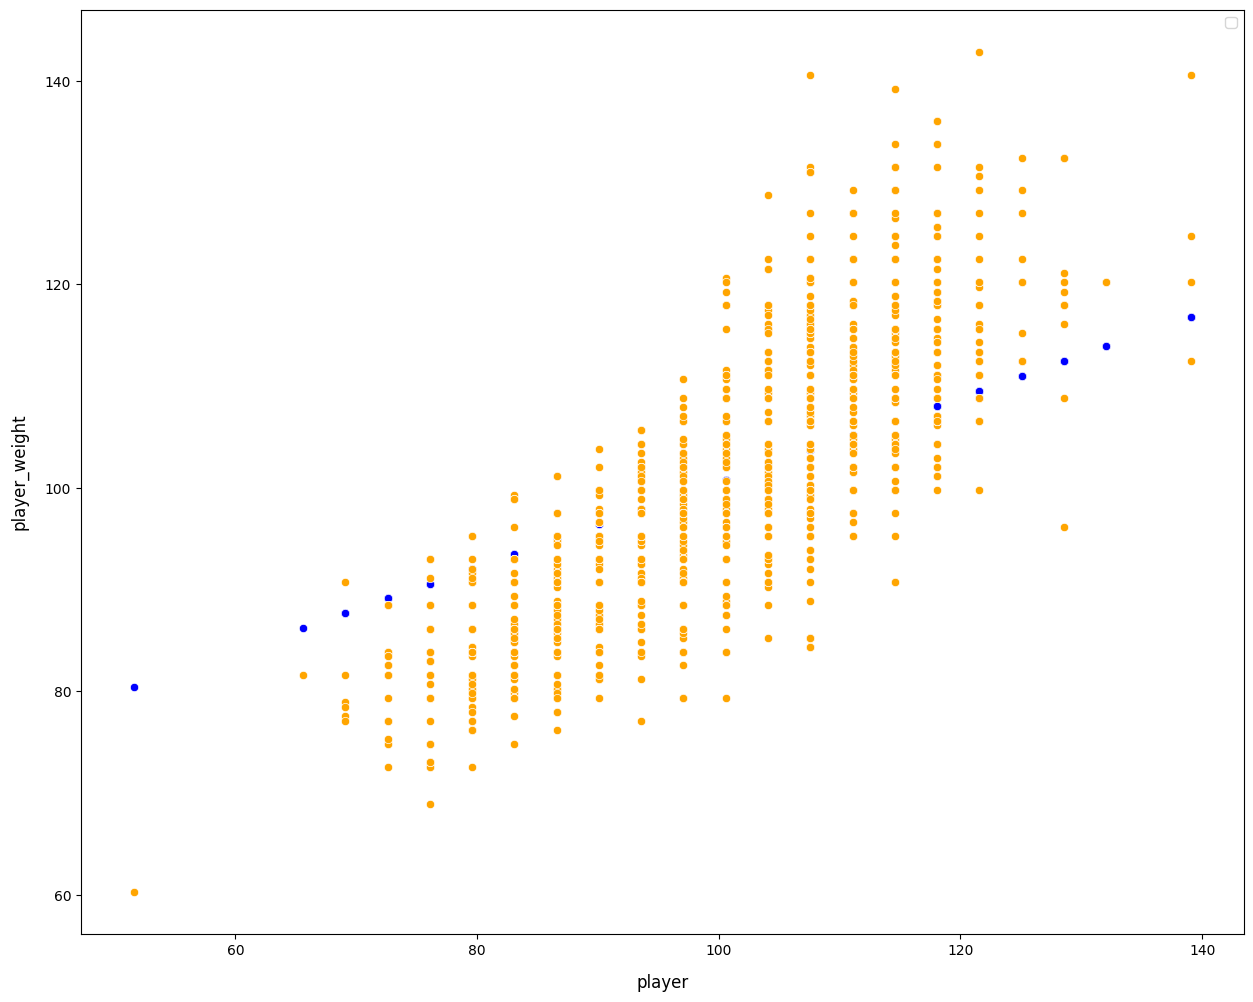

In [53]:
predictions = torch.matmul(X_test, W) + b

visualize_predictions(X_test, y_test, predictions)

### Model Using PyTorch Modules

#### Overall

PyTorch provides a wide array of configurable layers, optimizers, losses, and other utilities to create and train models effeciently

We'll be going through the steps in details, but overall the steps is as follow:
1. Prepare the dataset as tensors, either manually or using PyTorch dataset utilities 
2. Define the model as a class, inherited from PyTorch `nn.Module`, which has internal functions for training and evaluation
3. Define the optimizer, loss, ..etc
4. Create a training script
5. Evaluate

#### Creating the Dataset

Since we previously created the dataset manually, this time we will create it via PyTorch dataset utilities

In [54]:
batch_size = 2

In [55]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([7648, 1]),
 torch.Size([7648]),
 torch.Size([1913, 1]),
 torch.Size([1913]))

The first step is we create a `TensorDataset` which is a very basic utility to create dataset object from pure PyTorch tensors, PyTorch provides other utilities for images, text, ..etc using other official packages like: `torchvision`, `torchtext`, ..etc

In [56]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

The second step is to create a `dataloader` to load the dataset as batches, while implementing shuffling, sampling, ..etc 

In [57]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

#### Create the Model

The main goal here is to extend the `nn.Module` and implement to main functions:
1. `__init__`: initialise layers, params and other required inputs, eg: latent dimension, dynamic number of layers, ..etc 
2. `forward`: define the forward propagation process and return the output, which is a special function we will use later

In [58]:
class LinearRegression(nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        
        self.fc = nn.Linear(in_features=1, out_features=1, bias=True)
        
    def forward(self, x):
        output = self.fc(x)
        return output

Then we need to instantiate the model and move it to the GPU if available

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [60]:
model = LinearRegression()
model = model.to(device)

##### What's available in PyTorch nn.Module

###### Parameters

In [61]:
print(model.parameters())
print(list(model.parameters()))

<generator object Module.parameters at 0x165e77a00>
[Parameter containing:
tensor([[0.1571]], requires_grad=True), Parameter containing:
tensor([-0.9736], requires_grad=True)]


In [62]:
list(model.named_parameters())

[('fc.weight',
  Parameter containing:
  tensor([[0.1571]], requires_grad=True)),
 ('fc.bias',
  Parameter containing:
  tensor([-0.9736], requires_grad=True))]

###### Training / Evaluation mode

Switch between training mode and evaluation mode.

In trainig mode PyTorch will keep track of the weights and gradients

In evaluation mode PyTorch will run more effeciently on evaluation and won't track operations

In [63]:
model.train()

model.training

True

In [64]:
model.eval()


model.training

False

The forward method is a special method, where you can call the instance of your module and pass it the input

```python
output = model(inputs)
```

#### Define Optimizer and Loss

Loss function provided by PyTorch are self explanatory and don't include alot more that was covered before, except for more configuration

Optimizers are implementation of common optimizers eg: `SGD`, `Adam`, `RMSProp`, ..etc
They are resposbile for tracking the gradients and weights, and update accordingly. 
Although we're going to use them in a simple manner for now, they can do more.

Most importantly we call `optimizer.step()` to update the weights of the matrices



In [65]:
learning_rate = 1e-4

In [66]:
optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

#### Training

Similar to the last manual example, we're going to manually create a `for-loop` to iterate over epochs and batches

In [67]:
epochs = 10

In [68]:
# Ensure the model is in training mode
model.train()

# Iterate over epochs
for epoch in range(epochs):
    # Track loss per epoch
    epoch_loss = 0
    # For each epoch, go through all batches
    for batch in train_loader:
        # IMPORTANT: set the optimizer gradient to zero, to avoid gradient accumulation
        optimizer.zero_grad()
        
        # Each batch is a list of tensors,
        # as provided, index 0 is the inputs and index 1 is the target
        inputs, target = batch
        
        # Since our model is on the GPU, we need to move the tensors to GPU as well
        inputs, target = inputs.to(device), target.to(device)
        
        # Here we call the forward method to get the outputs from the model
        output = model(inputs)
        
        # Compute the loss, pass the predictions first and then the actual output
        loss = criterion(output, target)
        
        # Backward propagation
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        epoch_loss += loss.item()
        
    
    print(f"Epoch {epoch + 1}: Loss = {epoch_loss / len(train_loader.dataset)}")

/Users/anas/PythonProjects/PyTorch-learning/pytorch/lib/python3.12/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1: Loss = 0.6710332220112124
Epoch 2: Loss = 0.46941059603210367
Epoch 3: Loss = 0.42608490636421403
Epoch 4: Loss = 0.4157828333205909
Epoch 5: Loss = 0.4119450810120797
Epoch 6: Loss = 0.411123093161196
Epoch 7: Loss = 0.4104941879716622
Epoch 8: Loss = 0.41050043054455726
Epoch 9: Loss = 0.40450168276328285
Epoch 10: Loss = 0.41260467268388706


/var/folders/tg/jhy0d12925ldvjghgc440mjh0000gn/T/ipykernel_39493/2296896579.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/var/folders/tg/jhy0d12925ldvjghgc440mjh0000gn/T/ipykernel_39493/2296896579.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


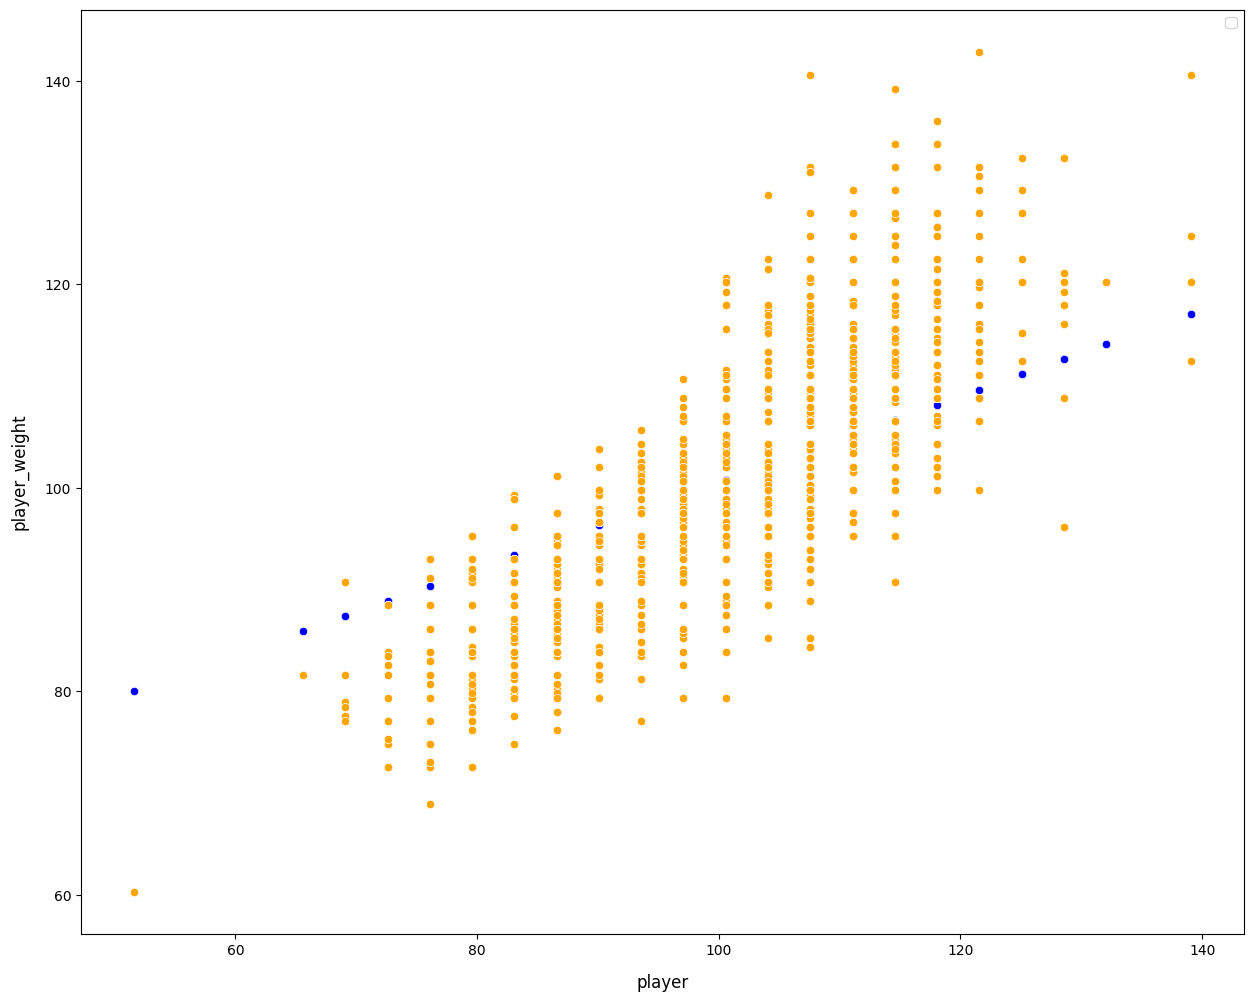

In [69]:
predictions = model(X_test)

visualize_predictions(X_test, y_test, predictions)    